In [29]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [30]:
def stock_data(stock_name, duration, company_name):#duration in years
   
    end_time = datetime.now()
    start_time = datetime(datetime.now().year - duration, datetime.now().month, datetime.now().day)  #using data of exactly duration year before
    stock=yf.download(stock_name,start_time,end_time)
    stock["comany_name"]=company_name
    return stock
def plot(df, company):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Adj Close'], color='blue', label='Adjusted Close')
    plt.title(f'Adjusted Close Prices for {company} Inc.')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()  
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed


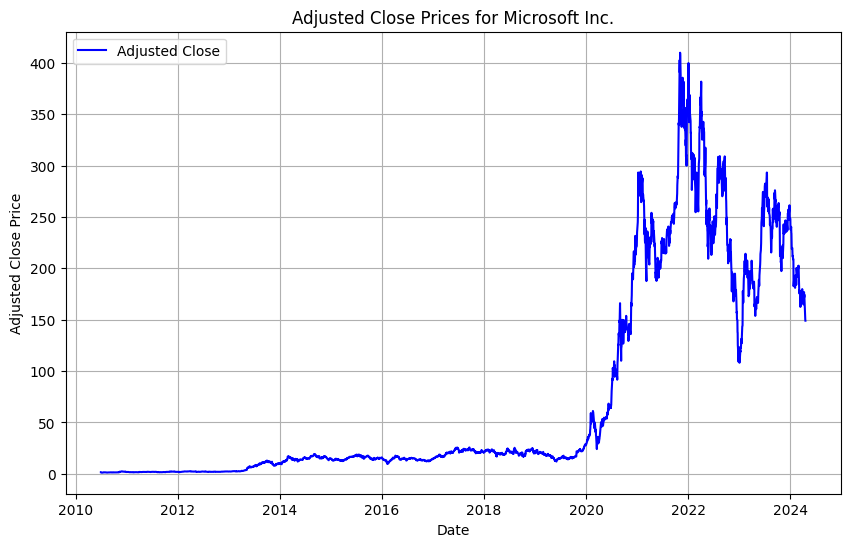

In [31]:
apple_stocks=stock_data('TSLA', 15,'Tesla')
plot(apple_stocks,'Microsoft')

In [32]:
from sklearn.preprocessing import MinMaxScaler
fit=MinMaxScaler(feature_range=(0,1))
unscaled_data=np.array(list(apple_stocks['Close']))
data=fit.fit_transform(np.array(list(apple_stocks['Close'])).reshape(-1,1))

In [33]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]

	
train_data,test_data=split_data(data, 65)

def create_dataset(data, step):
	X, Y = list(), list()

	for i in range(len(data)-step-1):
		X.append(data[i:(i+step), 0])
		Y.append(data[i + step, 0])
	return np.array(X), np.array(Y)

In [34]:
step = 100
x_train, y_train = create_dataset(train_data, step)
x_test, ytest = create_dataset(test_data, step)

#1 is representing the number of features we are using , here we are doing univariate LSTM . Therefore , 1
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [35]:
def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,1)))
    for i in range(1,numOfStacks-1):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(LSTM(num_neurons[-1]))
    
    model.add(Dense(1))
    return model

In [36]:
numOfStacks=3
num_neurons=[64,64,50]
model=make_model(step , numOfStacks,num_neurons)
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 64)           16896     
                                                                 
 lstm_7 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_8 (LSTM)               (None, 50)                23000     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 72971 (285.04 KB)
Trainable params: 72971 (285.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model.fit(x_train,y_train,validation_data=(x_test,ytest),epochs=100,batch_size=64,verbose=2)

Epoch 1/100
34/34 - 11s - loss: 1.6260e-04 - val_loss: 0.0219 - 11s/epoch - 330ms/step
Epoch 2/100
34/34 - 4s - loss: 1.2842e-05 - val_loss: 0.0154 - 4s/epoch - 115ms/step
Epoch 3/100
34/34 - 4s - loss: 8.4908e-06 - val_loss: 0.0102 - 4s/epoch - 113ms/step
Epoch 4/100
34/34 - 4s - loss: 8.5334e-06 - val_loss: 0.0104 - 4s/epoch - 116ms/step
Epoch 5/100
34/34 - 4s - loss: 8.2868e-06 - val_loss: 0.0109 - 4s/epoch - 110ms/step
Epoch 6/100
34/34 - 4s - loss: 7.3162e-06 - val_loss: 0.0110 - 4s/epoch - 108ms/step
Epoch 7/100
34/34 - 4s - loss: 7.3169e-06 - val_loss: 0.0088 - 4s/epoch - 109ms/step
Epoch 8/100
34/34 - 4s - loss: 7.1933e-06 - val_loss: 0.0092 - 4s/epoch - 113ms/step
Epoch 9/100
34/34 - 4s - loss: 6.7743e-06 - val_loss: 0.0104 - 4s/epoch - 112ms/step
Epoch 10/100
34/34 - 4s - loss: 6.8264e-06 - val_loss: 0.0090 - 4s/epoch - 109ms/step
Epoch 11/100
34/34 - 4s - loss: 6.7666e-06 - val_loss: 0.0096 - 4s/epoch - 111ms/step
Epoch 12/100
34/34 - 4s - loss: 6.5385e-06 - val_loss: 0.0083

In [39]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)    

train_predict=fit.inverse_transform(train_predict)
test_predict=fit.inverse_transform(test_predict)

35/35 [==============================] - 1s 27ms/step


In [40]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

14.273425807010232

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


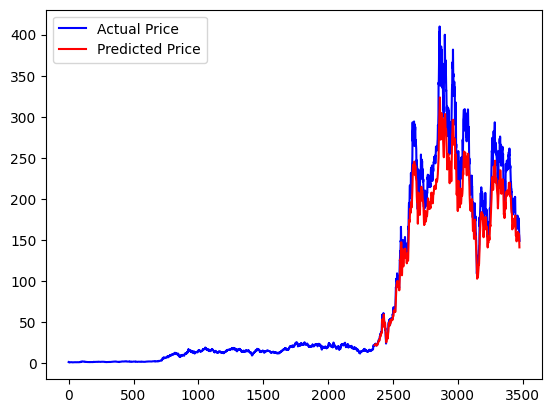

In [41]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
print(testPredictPlot)
testPredictPlot[len(train_predict)+(step*2)+1:len(data)-1] = test_predict
# Plot the actual data in blue and the predicted data in red
plt.plot(unscaled_data, color='blue', label='Actual Price')
plt.plot(testPredictPlot, color='red', label='Predicted Price')
plt.legend()
plt.show()